# Task 1 : Set up colab gpu runtime environment

In [54]:
# !pip install segmentation-models-pytorch
# !pip install -U git+https://github.com/albumentations-team/albumentations
# !pip install --upgrade opencv-contrib-python

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [55]:
# !git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

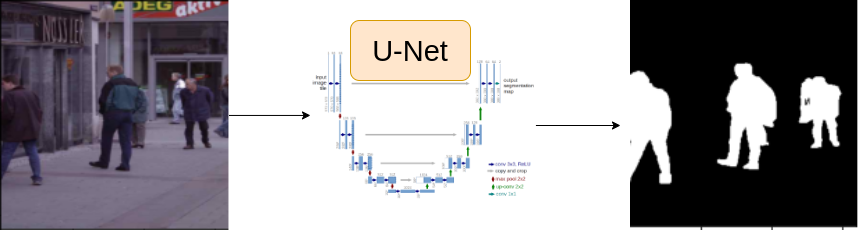

# Some Common Imports

In [1]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [2]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [3]:
CSV_FILE ='train.csv'
DATA_DIR ='/content/'

DEVICE ='cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE =  16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'


In [4]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [5]:
df = df.applymap(lambda x: x.replace("Human-Segmentation-Dataset-master/",''))
df.head()

,masks,images
0,Ground_Truth/1.png,Training_Images/1.jpg
1,Ground_Truth/10.png,Training_Images/10.jpg
2,Ground_Truth/100.png,Training_Images/100.jpg
3,Ground_Truth/101.png,Training_Images/101.jpg
4,Ground_Truth/102.png,Training_Images/102.jpg


In [6]:
row = df.iloc[4]
image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0

(408, 612, 3) (408, 612)


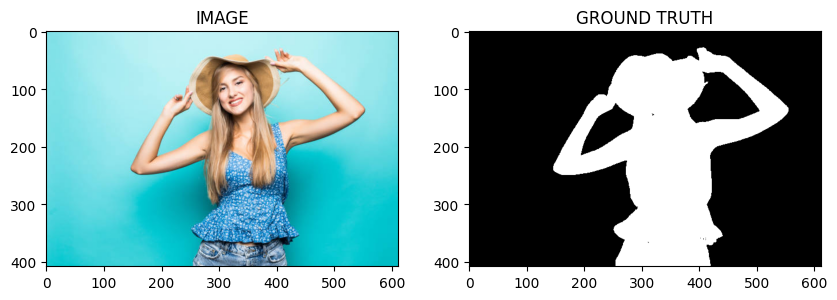

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')
print(image.shape, mask.shape)

In [8]:
df_train,df_val = train_test_split(df, test_size = 0.2,random_state = 40)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [9]:
import albumentations as A

In [10]:
def get_train_transforms():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ],is_check_shapes=False)

def get_val_transforms():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE),

  ],is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [11]:
from torch.utils.data import Dataset

In [43]:
class Humans(Dataset):
  def __init__ (self,df,transforms = None):
    self.df = df
    self.transforms = transforms

  def __len__(self):
    return len(self.df)

  def __getitem__(self,ind):
    row = self.df.iloc[ind]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)# (h,w)
    # mask = mask.unsqueeze(1)
    # mask = cv2.resize(mask, (image.shape[1], image.shape[0]))
    
    mask = np.expand_dims(mask,axis = -1)#(h,w,c)
    
    if self.transforms:
      data = self.transforms(image = image,mask =mask)
      image = data['image']
      mask = data['mask']

    #(h,w,c) -> (c,h,w)

    image = np.transpose(image,(2,0,1)).astype(np.float32)
    mask = np.transpose(mask,(2,0,1)).astype(np.float32)

    image = torch.Tensor(image)/255.0
    mask = torch.round(torch.Tensor(mask)/255.0)

    return image,mask




In [44]:
trainset =  Humans(df_train,get_train_transforms())
validset = Humans(df_val,get_val_transforms())

In [45]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


torch.Size([3, 320, 320]) torch.Size([1, 320, 320])


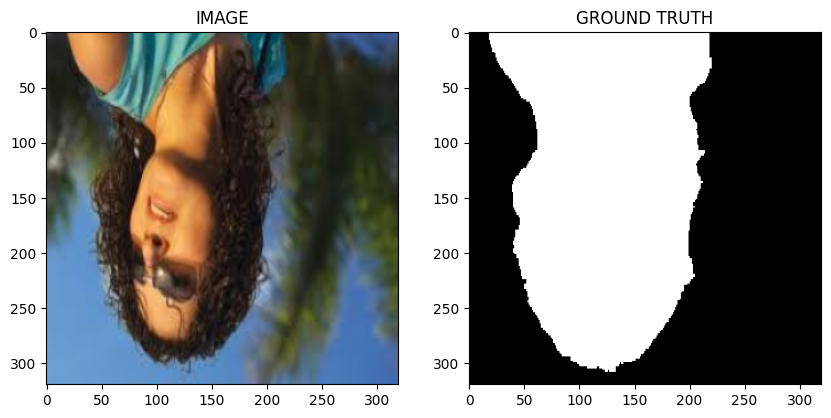

In [46]:
ind =10
image,mask = trainset[ind]
print(image.shape,mask.shape)
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [47]:
from torch.utils.data import DataLoader

In [48]:
trainloader = DataLoader(trainset,batch_size = BATCH_SIZE,shuffle = True)
validloader = DataLoader(validset,batch_size = BATCH_SIZE)

In [49]:
print(f"Size of Trainset : {len(trainloader)}")
print(f"Size of Validset : {len(validloader)}")


Size of Trainset : 15
Size of Validset : 4


In [52]:
for image,mask in trainloader:
  print(f"Image shape: {image.shape}")
  print(f"Mask shape:{mask.shape}")
  break


Image shape: torch.Size([16, 3, 320, 320])
Mask shape:torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [55]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss


In [56]:
class UNET(nn.Module):

  def __init__(self):
    super(UNET,self).__init__()

    self.arch = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes =1,
        activation =None
        #this will output logits
    )

  def forward(self,images,masks = None):
    logits = self.arch(images)

    if masks != None:
      loss1  = DiceLoss(mode='binary') (logits,masks)
      loss2 = nn.BCEWithLogitsLoss()(logits,masks)
      return logits,loss1 +loss2

    return logits


In [57]:
model = UNET()
model.to(DEVICE)


UNET(
  (arch): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): 

# Task 7 : Create Train and Validation Function

In [58]:
def train_fn(data_loader,model,optimizer):
  model.train()
  totloss = 0.0

  for images,masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits,loss = model(images,masks)
    loss.backward()
    optimizer.step()

    totloss += loss.item()

  return totloss/len(data_loader)

In [59]:
def eval_fn(data_loader,model):
  model.eval()
  totloss = 0.0

  with torch.no_grad():
    for images,masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)


      _,loss = model(images,masks)



      totloss += loss.item()

  return totloss/len(data_loader)

# Task 8 : Train Model

In [60]:
optimizer = torch.optim.Adam(model.parameters(),lr = LR)


In [61]:
best_val_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader,model,optimizer)
  val_loss = eval_fn(validloader,model)

  if val_loss < best_val_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print("Model Saved")
    best_val_loss = val_loss

  print(f"Epoch : {i+1} Train Loss:{train_loss} Val Loss:{val_loss}")


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


Model Saved
Epoch : 1 Train Loss:0.6949468851089478 Val Loss:2.173014760017395


100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


Model Saved
Epoch : 2 Train Loss:0.3603996018568675 Val Loss:0.5632353201508522


100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


Model Saved
Epoch : 3 Train Loss:0.316024112701416 Val Loss:0.4174070581793785


100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Model Saved
Epoch : 4 Train Loss:0.25518030921618146 Val Loss:0.2651193290948868


100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Model Saved
Epoch : 5 Train Loss:0.21177798608938853 Val Loss:0.21571149677038193


100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Model Saved
Epoch : 6 Train Loss:0.18706641445557276 Val Loss:0.2058469094336033


100%|██████████| 4/4 [00:02<00:00,  1.92it/s]


Epoch : 7 Train Loss:0.17711922625700632 Val Loss:0.25236406549811363


100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Model Saved
Epoch : 8 Train Loss:0.1598232641816139 Val Loss:0.18453995138406754


100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch : 9 Train Loss:0.17621693313121795 Val Loss:0.3286330848932266


100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


Epoch : 10 Train Loss:0.17418239613374073 Val Loss:0.2959137260913849


100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch : 11 Train Loss:0.170904145638148 Val Loss:0.2153513766825199


100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


Epoch : 12 Train Loss:0.24925370117028553 Val Loss:0.5364876762032509


100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


Epoch : 13 Train Loss:0.244226203362147 Val Loss:0.40353769063949585


100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


Epoch : 14 Train Loss:0.2399416943391164 Val Loss:0.23812567442655563


100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


Epoch : 15 Train Loss:0.20549377699693044 Val Loss:0.32876304537057877


100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


Epoch : 16 Train Loss:0.2075952058037122 Val Loss:0.2839958965778351


100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


Epoch : 17 Train Loss:0.17592147042353948 Val Loss:0.323374480009079


100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


Epoch : 18 Train Loss:0.16217819849650064 Val Loss:0.27205438166856766


100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


Epoch : 19 Train Loss:0.14332090218861898 Val Loss:0.2632357329130173


100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


Epoch : 20 Train Loss:0.15306061605612437 Val Loss:0.18845336139202118


100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


Epoch : 21 Train Loss:0.15210066984097162 Val Loss:0.20351416431367397


100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


Epoch : 22 Train Loss:0.12204727083444596 Val Loss:0.23107770271599293


100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


Model Saved
Epoch : 23 Train Loss:0.10111536631981531 Val Loss:0.16754810698330402


100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


Model Saved
Epoch : 24 Train Loss:0.0914707933863004 Val Loss:0.15194550529122353


100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

Epoch : 25 Train Loss:0.0923445095618566 Val Loss:0.15517130494117737


# Task 9 : Inference

In [86]:
ind = 0
model.load_state_dict(torch.load('best_model.pt'))
image,mask = validset[ind]#(c,h,w)
image = image.unsqueeze(0)#(1,c,h,w)
logits_mask = model(image.to(DEVICE))

pred = torch.sigmoid(logits_mask)
pred = (pred >0.5)*1.0
print(pred.shape)


torch.Size([1, 1, 320, 320])


In [87]:
temp=pred.detach().cpu().squeeze(0)
mask.shape

torch.Size([1, 320, 320])

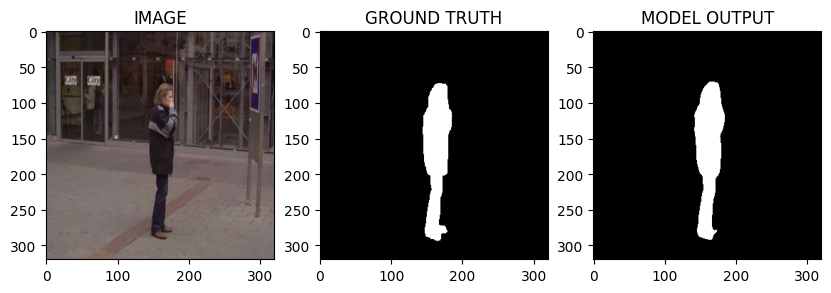

In [88]:
helper.show_image(image.detach().cpu().squeeze(0),mask,pred.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya